In [ ]:
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import pandas as pd 
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
# fill nan value with average
def fillNan(m):

    rows=len(m) 
    columns=m.shape[1]
 
    for j in range(0,columns):
        if m.columns[j] == 'date':
            continue
        m[m.columns[j]] = pd.to_numeric(m[m.columns[j]])
        sum1=0.0
        count=0.0
        for i in range(0,rows):
            if not (pd.isna(m[m.columns[j]][i])):
                sum1+=float(m[m.columns[j]][i])
                count+=1
        # in case all nan value 
        avg=sum1/max(count,1)
        for i in range(0,rows):
            if pd.isna(m[m.columns[j]][i]) or (float(m[m.columns[j]][i])==0):
                m[m.columns[j]][i]=avg
    return m

In [ ]:
#use mad delete extreme value
def MAD(dataset, n):
    median = np.median(dataset)  # 中位数
    deviations = abs(dataset - median)
    mad = np.median(deviations)
 
    remove_idx = np.where(abs(dataset - median) >  n * mad)
    new_data = np.delete(dataset, remove_idx)
 
    return new_data
# normalization data
def Normalization(x):
    return [(float(i)-min(x))/float(max(x)-min(x)) for i in x]

In [ ]:
def clean(ticker,url):
    #get df of stock
    df = pd.read_csv(url, index_col=0)
    
    stock_data = get_data(ticker, start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    stock_data.index=stock_data.index.to_period("M")
    #add monthly log return column
    stock_data['log_return'] = np.log(stock_data['close']).diff()
    
    
    df=df.drop(['open','high','low','close','adjclose','volume','ticker'],axis=1)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period('M')
    df = df.join(stock_data)
    
    #drop the columns when all rows of this columns are all nan
    df=df.dropna(how='all',axis=1)
    df = df.replace(',','', regex=True)
    df.columns = df.columns.str.replace('\t', '')
    df=df.drop(['open','close','high','low','ticker'],axis=1)
    df = fillNan(df)
    df['adjclose'] = MAD(df['adjclose'],n=5)
    #df['adjclose'] = Normalization(df['adjclose'])
    if 'Cushing OK WTI Spot Price FOB Dollars per Barrel' in df.columns:
        df=df.rename({'Cushing OK WTI Spot Price FOB Dollars per Barrel' : 'OilPrice'}, axis=1)
        
    #join sp500 index
    sp_data = get_data('^GSPC', start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    sp_data.index=sp_data.index.to_period("M")
    df['sp500'] = sp_data['adjclose']
    return df

In [ ]:
data=clean('dis', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/dis_macro.csv')
data = data.iloc[::-1]
data.head()

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg


TotalRevenue  OperatingRevenue  CostOfRevenue  GrossProfit  \
date                                                                  
2010-03    8580000000        8580000000     7068000000   1512000000   
2010-06   10002000000       10002000000     7723000000   2279000000   
2010-09    9742000000        9742000000     8221000000   1521000000   
2010-12   10716000000       10716000000     8776000000   1940000000   
2011-03    9077000000        9077000000     7549000000   1528000000   

         OperatingExpense  SellingGeneralAndAdministration  \
date                                                         
2010-03      2.806000e+09                     2.470731e+09   
2010-06      2.806000e+09                     2.470731e+09   
2010-09      2.806000e+09                     2.470731e+09   
2010-12      2.806000e+09                     2.470731e+09   
2011-03      2.806000e+09                     2.470731e+09   

         DepreciationAmortizationDepletionIncomeStatement  \
date                                                        
2010-03                                      8.748846e+08   
2010-06                                      8.748846e+08   
2010-09                                      8.748846e+08   
2010-12                                      8.748846e+08   
2011-03                                      8.748846e+08   

         DepreciationAndAmortizationInIncomeStatement  OperatingIncome  \
date                                                                     
2010-03                                  8.748846e+08       1512000000   
2010-06                                  8.748846e+08       2279000000   
2010-09                                  8.748846e+08       1521000000   
2010-12                                  8.748846e+08       1940000000   
2011-03                                  8.748846e+08       1528000000   

         NetNonOperatingInterestIncomeExpense  ...  \
date                                           ...   
2010-03                            -130000000  ...   
2010-06                             -89000000  ...   
2010-09                             -87000000  ...   
2010-12                             -95000000  ...   
2011-03                             -83000000  ...   

         EnterprisesValueRevenueRatio  EnterprisesValueEBITDARatio        GDP  \
date                                                                            
2010-03                         9.076                       37.278  14721.350   
2010-06                         7.136                       24.859  14926.098   
2010-09                         7.523                       37.469  15079.917   
2010-12                         7.535                       30.925  15240.843   
2011-03                        10.081                       42.861  15285.828   

         Inflation  ExchangeRate  UnemploymentRate   adjclose     volume  \
date                                                                       
2010-03   2.333333      6.827640          9.833333  30.407646  306740800   
2010-06   1.766667      6.824717          9.633333  27.437429  288582900   
2010-09   1.133333      6.770695          9.466667  28.831081  214082100   
2010-12   1.266667      6.658365          9.500000  32.672321  157233100   
2011-03   2.133333      6.580304          9.033333  37.943199  213021500   

         log_return        sp500  
date                              
2010-03    0.111074  1169.430054  
2010-06   -0.059167  1030.709961  
2010-09    0.017063  1141.199951  
2010-12    0.027021  1257.640015  
2011-03   -0.014972  1325.829956  

[5 rows x 68 columns]

In [ ]:
# test_data = data[['OperatingRevenue', 'CostOfRevenue', 'OperatingExpense', 
#         'TaxProvision','NetIncome',
#        'BasicEPS',  'BasicAverageShares', 
#        'TotalExpenses', 
#        'NormalizedIncome', 'InterestIncome', 'InterestExpense',
#        'NetInterestIncome', 'EBIT',  
#        'TotalUnusualItems',
#         'TaxEffectOfUnusualItems',
#         'volume', 'MarketCap',
#        'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
#        'PbRatio'
       
#     ]]

test_data = data[[
       'BasicEPS',  'BasicAverageShares',  
       'InterestIncome', 
       'NetInterestIncome',  
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap', 'PeRatio', 'PegRatio'
       
    ]]

# test_data = data[[
#        'BasicEPS',   
#        'NetInterestIncome',  
#         'TaxEffectOfUnusualItems',
#         'volume', 'MarketCap', 'PeRatio','sp500'
       
#     ]]

# test_data = data[[
#        'BasicEPS','volume','NetInterestIncome','PeRatio','sp500'
       
#     ]]


#Variance inflation factor (VIF)
def vif(df, col_i):
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

efficient_col=[]
for i in test_data.columns:
    print(i, '\t', vif(test_data, col_i=i))
    if float(vif(test_data,col_i=i))<20:
        efficient_col.append(i)

# check if there is an zero 
# test_data.all(axis='columns')


BasicEPS 	 2.821839380117587
BasicAverageShares 	 2.348965464888436
InterestIncome 	 1.2971852681807137
NetInterestIncome 	 2.800870328232669
TaxEffectOfUnusualItems 	 2.5554407862173356
volume 	 2.992894177819093
MarketCap 	 2.832147139487747
PeRatio 	 1.4063177056102227
PegRatio 	 1.5490736139165997


In [ ]:
X = test_data # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
for i in X.columns:
    X[i] = Normalization(X[i])
Y = data['adjclose']
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               adjclose   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     51.40
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           1.54e-17
Time:                        13:01:00   Log-Likelihood:                -125.99
No. Observations:                  45   AIC:                             272.0
Df Residuals:                      35   BIC:                             290.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

<ipython-input-137-4b27697f04c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = Normalization(X[i])


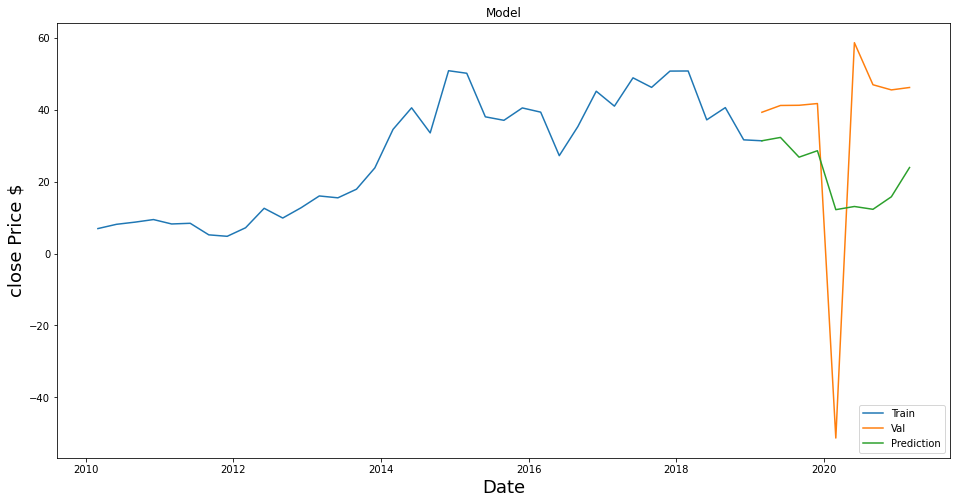

In [ ]:
# use efficient columns to make predict
train_x = X[:int(0.8*len(X))+1]
train_y = Y[:int(0.8*len(Y))+1]

test_x = X[int(0.8*len(X)):]
test_y = Y[int(0.8*len(Y)):]

est = sm.OLS(train_y, train_x.astype(float)).fit()

y_pred = est.predict(test_x)

df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
df.index = df.index.to_timestamp()
train_y.index = train_y.index.to_timestamp()
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('close Price $',fontsize=18)
plt.plot(train_y)
plt.plot(df['Predicted'])
plt.plot(df['Actual'])
plt.legend(['Train','Val','Prediction'],loc='lower right')



In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 13.170814866573469
Mean Squared Error: 411.1460685053635
Root Mean Squared Error: 20.276737126701708


In [ ]:
errors = abs(y_pred - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 13.17 degrees.
Accuracy: 15.36 %.


In [ ]:
def model_predict(data):
#     test_data = data[['OperatingRevenue',
#        'BasicEPS',  'BasicAverageShares',  
#        'NormalizedIncome', 
#        'NetInterestIncome',  
#         'TaxEffectOfUnusualItems',
#         'volume', 'MarketCap', 'PeRatio'
       
#     ]]
#     test_data = data[[
#        'BasicEPS',  'BasicAverageShares',   
#        'NetInterestIncome',  
#         'TaxEffectOfUnusualItems',
#         'volume', 'MarketCap', 'PeRatio'
       
#     ]]

    test_data = data[[
           'BasicEPS',   
           'NetInterestIncome',  
            'TaxEffectOfUnusualItems',
            'volume', 'MarketCap', 'PeRatio','sp500'

        ]]

    for i in test_data.columns:
        test_data[i] = Normalization(test_data[i])
    
    train_x = test_data[:int(0.8*len(X))+1]
    train_y = data['adjclose'][:int(0.8*len(Y))+1]
    train_X = sm.add_constant(train_x)
    
    test_x = test_data[int(0.8*len(X)):]
    test_y = data['adjclose'][int(0.8*len(Y)):]
    est = sm.OLS(train_y, train_x.astype(float)).fit()
    
    print(est.summary())
    
    y_pred = est.predict(test_x)


    df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
    df.index = df.index.to_timestamp()
    train_y.index = train_y.index.to_timestamp()
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('close Price $',fontsize=18)
    plt.plot(train_y)
    plt.plot(df['Predicted'])
    plt.plot(df['Actual'])
    plt.legend(['Train','Val','Prediction'],loc='lower right')
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))
    errors = abs(y_pred - test_y)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_y)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              1264.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    2.92e-35
Time:                        13:04:08   Log-Likelihood:                         -127.92
No. Observations:                  37   AIC:                                      269.8
Df Residuals:                      30   BIC:                                      281.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'Coke Model')

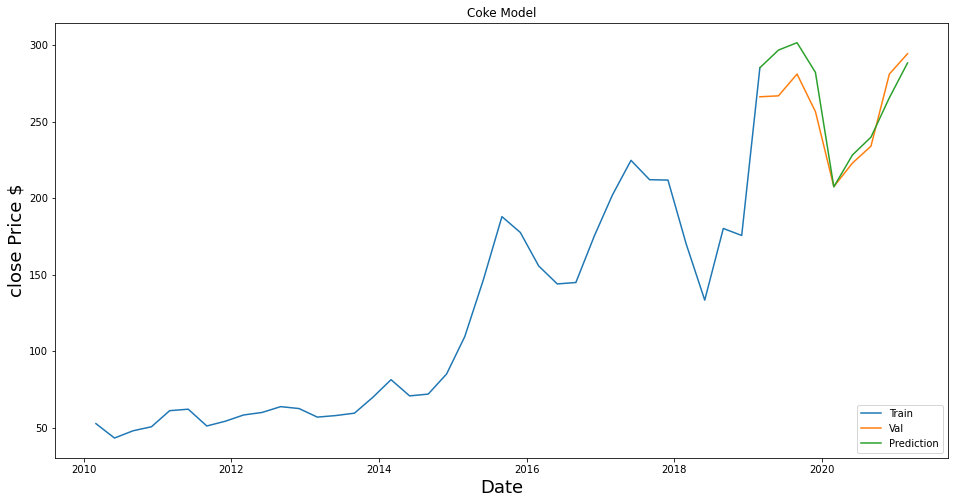

In [ ]:
# COKE 
data_COKE = clean('coke','https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/coke_macro.csv')
data_COKE = data_COKE.iloc[::-1]
model_predict(data_COKE)
plt.title('Coke Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              985.1
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    1.21e-33
Time:                        13:05:15   Log-Likelihood:                         -112.72
No. Observations:                  37   AIC:                                      239.4
Df Residuals:                      30   BIC:                                      250.7
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'PepsiCo Model')

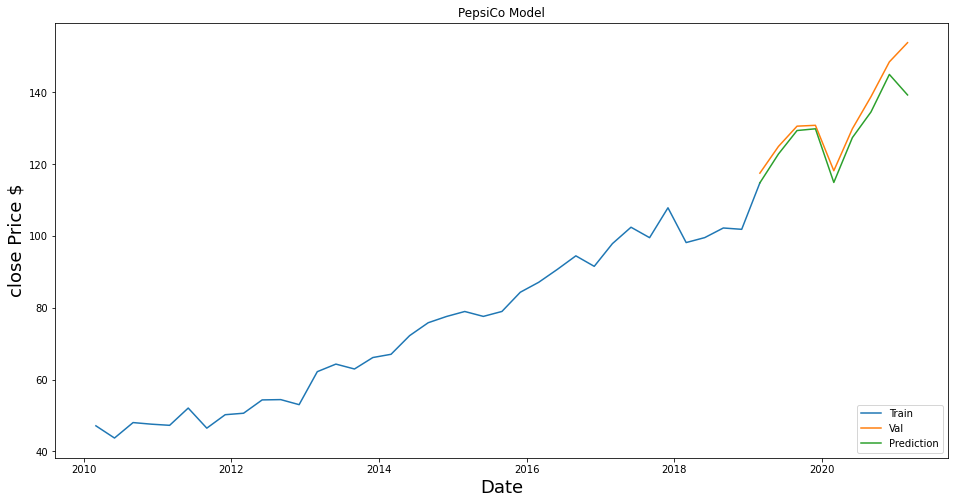

In [ ]:
# pep
data_pep = clean('pep','https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/pep_quarterly_with_sugar_price.csv')
data_pep = data_pep.iloc[::-1]
model_predict(data_pep)
plt.title('PepsiCo Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              3743.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    2.57e-42
Time:                        13:05:42   Log-Likelihood:                         -88.701
No. Observations:                  37   AIC:                                      191.4
Df Residuals:                      30   BIC:                                      202.7
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'Disney Model')

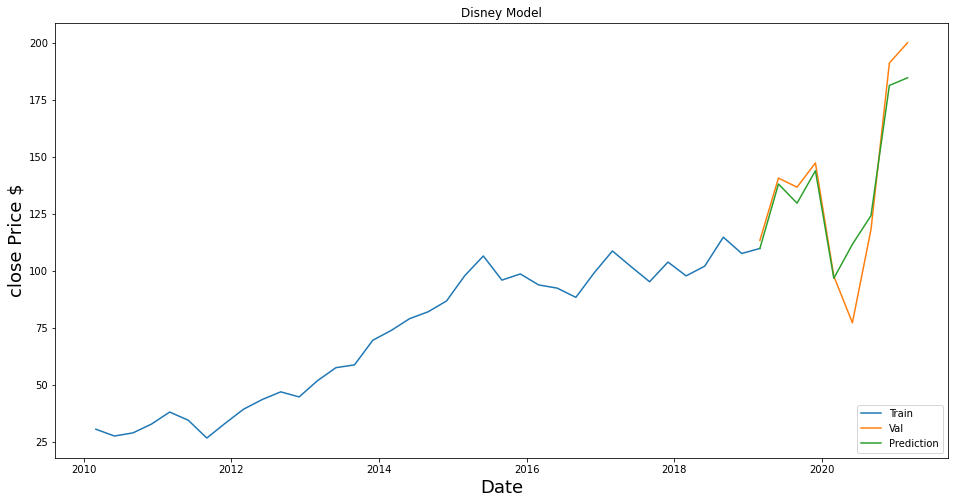

In [ ]:
data=clean('dis', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/dis_macro.csv')
data = data.iloc[::-1]
model_predict(data)
plt.title('Disney Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.029e+04
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    4.82e-63
Time:                        13:16:39   Log-Likelihood:                         -52.921
No. Observations:                  37   AIC:                                      119.8
Df Residuals:                      30   BIC:                                      131.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'Netflex Model')

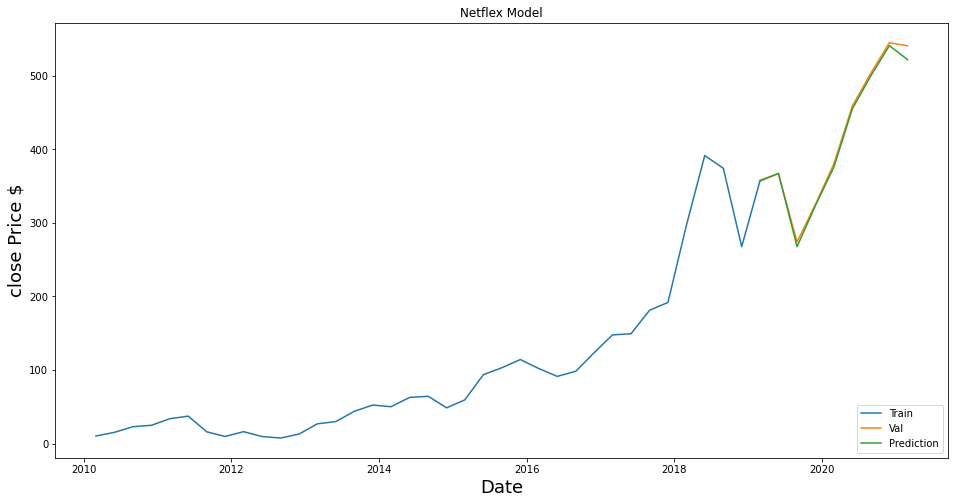

In [ ]:
def clean(ticker,url):
    #get df of stock
    df = pd.read_csv(url, index_col=0)
    
    stock_data = get_data(ticker, start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    stock_data.index=stock_data.index.to_period("M")
    #add monthly log return column
    stock_data['log_return'] = np.log(stock_data['close']).diff()
    
    
    df=df.drop(['open','high','low','close','adjclose','volume','ticker'],axis=1)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period('M')
    df = df.join(stock_data)
    
    #drop the columns when all rows of this columns are all nan
    df=df.dropna(how='all',axis=1)
    df = df.replace(',','', regex=True)
    df.columns = df.columns.str.replace('\t', '')
    df=df.drop(['open','close','high','low','ticker'],axis=1)
    df = fillNan(df)
#     df['adjclose'] = MAD(df['adjclose'],n=5)
    #df['adjclose'] = Normalization(df['adjclose'])
    if 'Cushing OK WTI Spot Price FOB Dollars per Barrel' in df.columns:
        df=df.rename({'Cushing OK WTI Spot Price FOB Dollars per Barrel' : 'OilPrice'}, axis=1)
        
    #join sp500 index
    sp_data = get_data('^GSPC', start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    sp_data.index=sp_data.index.to_period("M")
    df['sp500'] = sp_data['adjclose']
    return df

data=clean('nflx', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/nflx_macro.csv')
data = data.iloc[::-1]
model_predict(data)
plt.title('Netflex Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              340.3
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    8.83e-27
Time:                        13:19:40   Log-Likelihood:                         -98.378
No. Observations:                  37   AIC:                                      210.8
Df Residuals:                      30   BIC:                                      222.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'Sony Model')

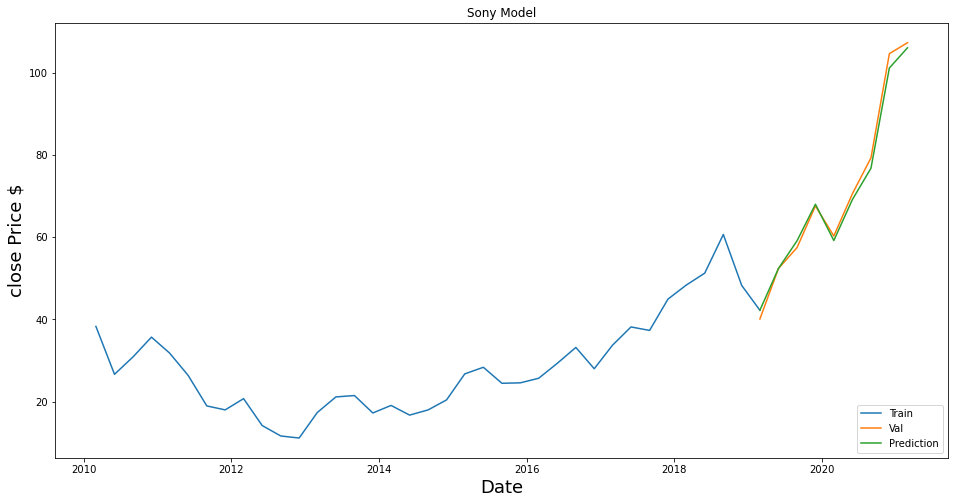

In [ ]:
#Sony 


data=clean('sony', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/sony_macro.csv')
data = data.iloc[::-1]
model_predict(data)
plt.title('Sony Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              486.3
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    4.45e-29
Time:                        13:06:07   Log-Likelihood:                         -92.961
No. Observations:                  37   AIC:                                      199.9
Df Residuals:                      30   BIC:                                      211.2
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'American Airline Model')

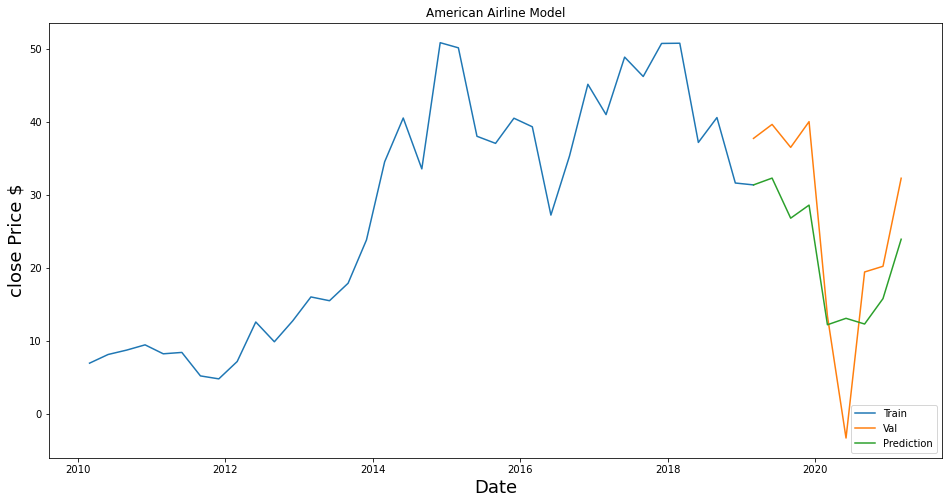

In [ ]:
#aal
data=clean('aal', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/aal_macro.csv')
data = data.iloc[::-1]
model_predict(data)
plt.title('American Airline Model')

<ipython-input-2-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg
<ipython-input-112-a2d57ce810ca>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[i] = Normalization(test_data[i])


                                 OLS Regression Results                                
Dep. Variable:               adjclose   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              313.0
Date:                Fri, 06 Aug 2021   Prob (F-statistic):                    3.03e-26
Time:                        13:13:12   Log-Likelihood:                         -101.02
No. Observations:                  37   AIC:                                      216.0
Df Residuals:                      30   BIC:                                      227.3
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Text(0.5, 1.0, 'Delta Model')

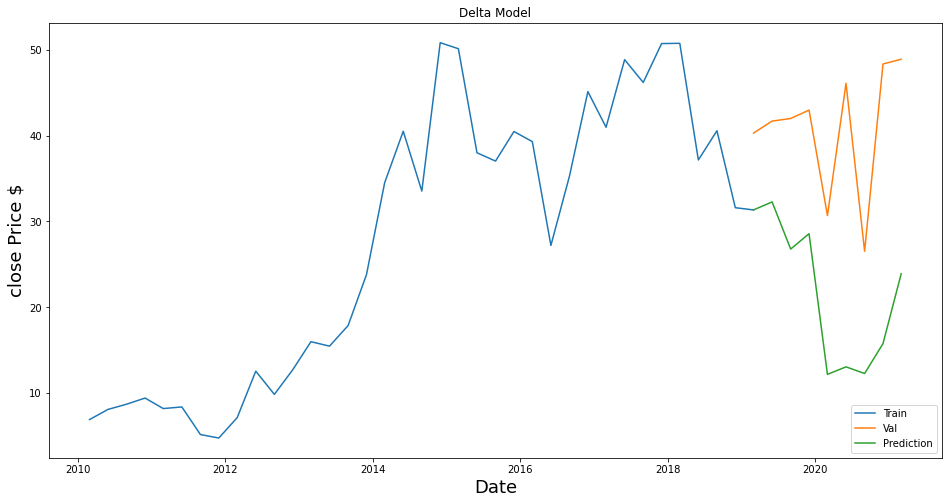

In [ ]:
# delta


data=clean('aal', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/dal_macro.csv')
data = data.iloc[::-1]
model_predict(data)
plt.title('Delta Model')

In [ ]:
'''
Model fit and performs better in Technology stocks, such as Disney, NetFlex and sony. Performs worse in airline stocks,
possiabily becasue of the Covid issue, which casue Airline stocks have an unusual huge down trend and high volitality.

In airline sector, factors like Market cap, Netinterest income have low P value (less than 0.05) and high coefficient in
regression results.


'''
